In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
from itertools import product
import gensim
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

## First Patient Set (females)

In [4]:
#load patient vectors from HMP-T2D
vec_p1 = pickle.load(open("vec_p1.p", "rb"))
vec_p2 = pickle.load(open("vec_p2.p", "rb"))
vec_p3 = pickle.load(open("vec_p3.p", "rb"))
vec_p4 = pickle.load(open("vec_p4.p", "rb"))

In [5]:
#a vector (length 10) for each sequence that is an average of all 6 'versions' of that sequence
#should be equal to number of original reads per patient
print('Vectors in P1:', len(vec_p1))
print('Vectors in P2:', len(vec_p2))
print('Vectors in P3:', len(vec_p3))
print('Vectors in P4:', len(vec_p4))

Vectors in P1: 16293
Vectors in P2: 16907
Vectors in P3: 15241
Vectors in P4: 21330


## PCA

In [6]:
X = np.concatenate((vec_p1, vec_p2, vec_p3, vec_p4))
y = np.concatenate((np.ones(29379), np.full(28329, 2), np.full(22485, 3), np.full(13821, 4)))

In [7]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(X)
pcafeatures_train = pca.transform(X)

In [8]:
# Create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['#d6f6dd', '#eb5e55', '#697268'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [9]:
# plot PC1 vs PC2 of all the sequences
plot_PCA_2D(pcafeatures_train, target=y, target_names=['patient 1', 'patient 2', 'patient 3', 'patient 4'])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 69771 but corresponding boolean dimension is 94014

<Figure size 720x720 with 0 Axes>

## Clustering

### MeanShift

In [18]:
X = np.concatenate((vec_p1, vec_p2, vec_p3, vec_p4))
y = np.concatenate((np.ones(29379), np.full(28329, 2), np.full(22485, 3), np.full(13821, 4)))

In [19]:
# estimate bandwidth 
bandwidth = estimate_bandwidth(cluster_p1, quantile=0.4, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 8


In [ ]:
plot_PCA_2D(pcafeatures_train, target=labels, target_names=['cluster' + str(x+1) for x in range(n_clusters_)])

In [21]:
cluster_centers

array([[-0.51143795,  0.6925811 , -0.5718237 , -0.57003933,  0.7740009 ,
         0.6475506 , -0.45654902,  0.04843059,  0.60572904,  0.48809707],
       [-0.4390063 ,  0.56485265, -0.4549197 , -0.49786037,  0.661549  ,
         0.60302997, -0.4471773 ,  0.05817059,  0.54102755,  0.44037068],
       [-0.658891  ,  0.62697905, -0.12951982, -0.48541665,  0.5262368 ,
         0.66685456, -0.14781897,  0.15898329,  0.42033204,  0.36508548],
       [-0.31347334,  0.554246  , -0.56251514, -0.3830982 ,  0.5854267 ,
         0.5580742 , -0.35885322,  0.10637879,  0.5304577 ,  0.35744146],
       [-0.51872957,  0.66098005, -0.39469332, -0.5113335 ,  0.6603103 ,
         0.74768704, -0.33479252,  0.12703134,  0.5161132 ,  0.4238264 ],
       [-0.55425733,  0.646637  , -0.24222702, -0.5096577 ,  0.5293952 ,
         0.6430279 , -0.2838495 ,  0.16462627,  0.39362362,  0.40999424],
       [-0.62258714,  0.69863623, -0.24962774, -0.49729425,  0.56119287,
         0.69011813, -0.27840468,  0.12798426

In [ ]:
#find number of points within each cluster
y = np.bincount(labels)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii]))

### Heirarchical

[(0, 7422), (1, 5507), (2, 3364)]
[(0, 4722), (1, 9964), (2, 2221)]
[(0, 4587), (1, 7543), (2, 3111)]
[(0, 11070), (1, 2844), (2, 7416)]


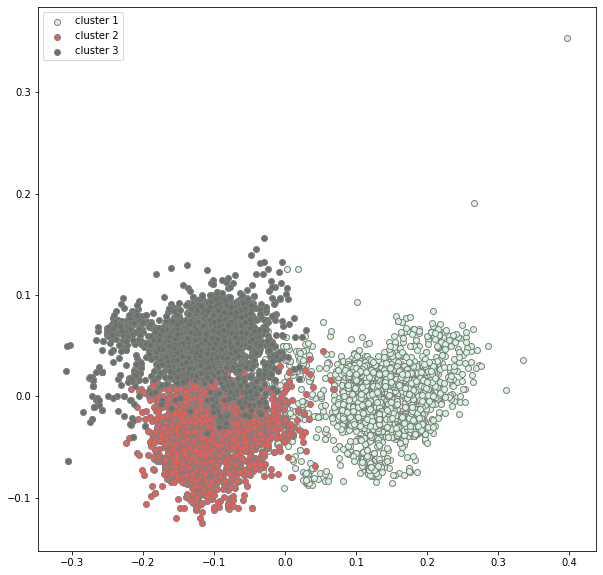

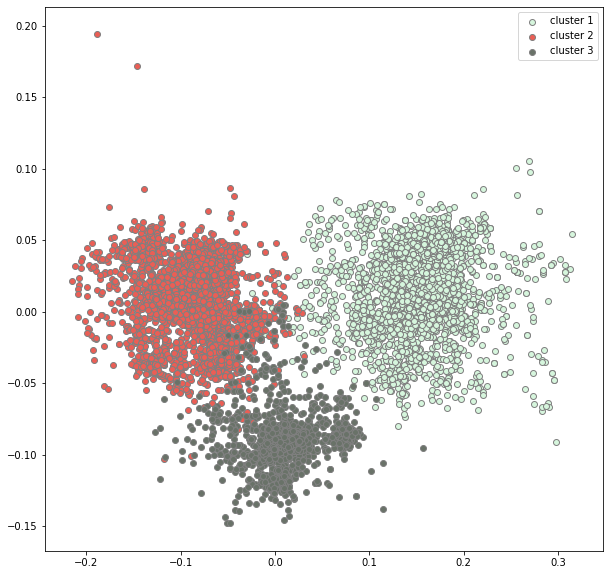

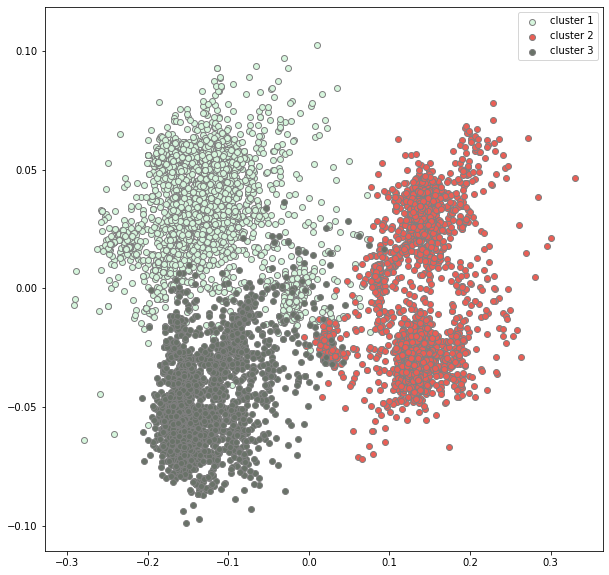

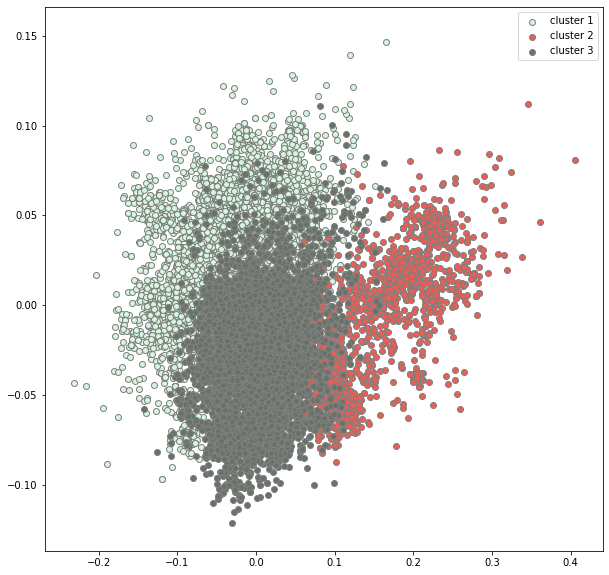

In [11]:
#get cluster labels and determine number of points within each cluster

hc_labels = []
children = []

for ind,patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    hc = AgglomerativeClustering(linkage='ward', n_clusters=3)
    hc.fit(patient)
    labels = hc.labels_
    y = np.bincount(labels)
    ii = np.nonzero(y)[0]
    print(list(zip(ii,y[ii])))
    hc_labels.append(labels)
    children.append(hc.children_)
    
    #plot using pc1/pc2
    pca = PCA(n_components=2)
    pca.fit(patient)
    pcafeatures_train = pca.transform(patient)

    plot_PCA_2D(pcafeatures_train, target=hc_labels[ind], 
            target_names=['cluster 1', 'cluster 2', 'cluster 3'])

In [12]:
def find_nearest(vectors, center):
    current_min = (0, 1)
    for i, vector in enumerate(vectors):
        new_min = (i, sum(np.abs(np.subtract(np.asarray(vector), np.asarray(center)))))
        if new_min[1] < current_min[1]:
            current_min = new_min
    return current_min

In [13]:
#find "centers" of agglomerative clustering
#actually it's the average of all points of that cluster in the 10-dim space
#find_nearest returns the vector that is "nearest" to the determined "center"
def find_center(labels, num_clusters, vectors):
    hc_centers = []
    actual_centers = []
    for clust in range(num_clusters):
        clust_ind = [i for i, x in enumerate(labels) if x == clust]
        vec_ind = [vectors[i] for i in clust_ind]
        hc_centers.append(sum(vec_ind)/len(clust_ind))
    
    for center in hc_centers:
        actual_centers.append(find_nearest(vectors, center))
    return actual_centers

### this returns the index and distance from the calculated 'center' of the representative sequences for each cluster
#these can be plugged back into the original data in order to BLAST the representative sequences to interpret species

In [16]:
 
for ind, patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    cents = find_center(hc_labels[ind], 3, patient)
    print('Centers for Patient', ind+1)
    print(cents)

Centers for Patient 1
[(5303, 0.062530517578125), (1287, 0.06512436270713806), (1352, 0.058869872242212296)]
Centers for Patient 2
[(15354, 0.0789768435060978), (3206, 0.04165816679596901), (1658, 0.03677870333194733)]
Centers for Patient 3
[(3098, 0.04043500032275915), (4332, 0.06814591959118843), (166, 0.056820742785930634)]
Centers for Patient 4
[(2530, 0.052955593913793564), (11871, 0.10818596929311752), (4553, 0.05725898966193199)]


In [27]:
def sort_tuple(tup):       
    # getting length of list of tuples 
    lst = len(tup)  
    for i in range(0, lst):  
        for j in range(0, lst-i-1):  
            if (tup[j][1] > tup[j + 1][1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup

In [28]:
def find_five_nearest(vectors, center):
    mins = []
    for i, vector in enumerate(vectors):
        mins.append((i, sum(np.abs(np.subtract(np.asarray(vector), np.asarray(center))))))
    return sort_tuple(mins)[0:5]

In [29]:
def find_five(labels, num_clusters, vectors):
    hc_centers = []
    actual_centers = []
    for clust in range(num_clusters):
        clust_ind = [i for i, x in enumerate(labels) if x == clust]
        vec_ind = [vectors[i] for i in clust_ind]
        hc_centers.append(sum(vec_ind)/len(clust_ind))
    
    for center in hc_centers:
        actual_centers.append(find_five_nearest(vectors, center))
    return actual_centers

In [30]:
for ind, patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    cents = find_five(hc_labels[ind], 3, patient)
    print('Centers for Patient', ind+1)
    print(cents)

Centers for Patient 1
[[(5303, 0.062530517578125), (12793, 0.06406445801258087), (12254, 0.06822000443935394), (10403, 0.06916055828332901), (11566, 0.07004465907812119)], [(1287, 0.06512436270713806), (1288, 0.06512436270713806), (10266, 0.06556109338998795), (5160, 0.06904226914048195), (5161, 0.06904226914048195)], [(1352, 0.058869872242212296), (12030, 0.06376427412033081), (12716, 0.06653611361980438), (5840, 0.06744356825947762), (8704, 0.06820418313145638)]]
Centers for Patient 2
[[(15354, 0.0789768435060978), (6096, 0.09332884475588799), (16065, 0.10071359947323799), (13990, 0.10213891044259071), (16884, 0.10277765989303589)], [(3206, 0.04165816679596901), (14324, 0.0489337295293808), (9272, 0.05403076857328415), (8358, 0.05415985360741615), (14389, 0.05616842955350876)], [(1658, 0.03677870333194733), (1659, 0.03677870333194733), (16245, 0.03704017400741577), (11657, 0.03960828483104706), (8434, 0.042845405638217926)]]
Centers for Patient 3
[[(3098, 0.04043500032275915), (12088